In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import os

#### TEST EMBEDDING

In [2]:
import torch
# Load the saved embeddings & labels
train_emb = torch.load("./train_embedding.pt", weights_only=True)
val_emb = torch.load("./val_embedding.pt", weights_only=True)
test_emb = torch.load("./test_embedding.pt", weights_only=True)

In [6]:
train_emb["X"].shape

torch.Size([15240192, 128])

In [4]:
test_data.X

array([[0.        , 0.        , 1.3239822 , ..., 0.08834465, 2.5304163 ,
        0.        ],
       [0.0838345 , 0.        , 0.15988916, ..., 0.01608151, 0.        ,
        1.3793153 ],
       [0.21246816, 2.685146  , 0.29428506, ..., 3.2449088 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.11297436, 0.4489409 , ..., 1.0449735 , 0.        ,
        0.2686398 ],
       [0.        , 0.        , 0.16783972, ..., 0.4124021 , 0.642095  ,
        0.48151803],
       [1.4278795 , 1.4686954 , 0.24211796, ..., 6.084745  , 0.        ,
        0.5815471 ]], shape=(200000, 128), dtype=float32)

Plot ovrerall predictions

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'y_true' as categorical
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'y_pred' as categorical


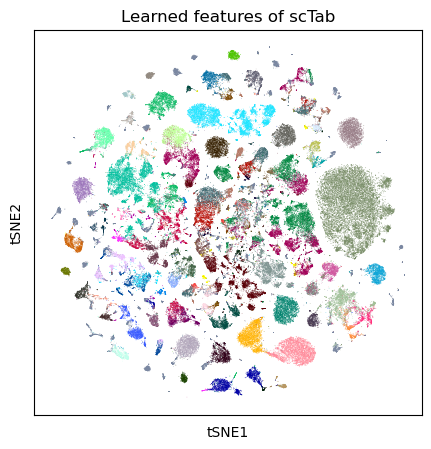

In [4]:
import yaml
with open('/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/notebooks/data_augmentation/shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

plt.rcParams['figure.figsize'] = (5, 5)

cell_freq = test_data.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq.index.tolist()[:70]
adata_plot = test_data.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot)).astype(str)
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot)).astype(str)

# convert to shortened cell type names
adata_plot.obs['y_pred'] = adata_plot.obs['y_pred'].replace(shortend_cell_types)
adata_plot.obs['y_true'] = adata_plot.obs['y_true'].replace(shortend_cell_types)

ax = sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1, title='Learned features of scTab', show=False)
ax.get_legend().remove()

Overall predictions

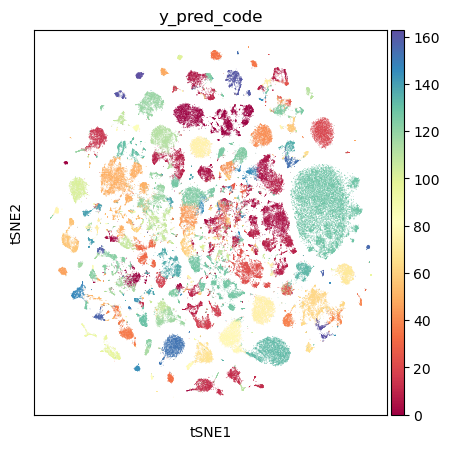

In [5]:
test_data.obs['y_pred_code'] = test_data.obs['y_pred'].cat.codes
sc.pl.tsne(test_data, color='y_pred_code', cmap='Spectral')

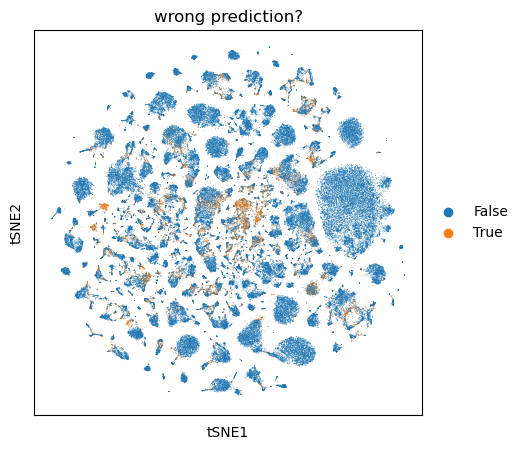

In [6]:
sc.pl.tsne(
    test_data, 
    color='wrong_prediction', 
    title='wrong prediction?',
    # save='_wrong_predictions.png'
)

#### VALID EMBEDDING

In [12]:
# Paths
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-checkpoints/scTab/run4/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [18]:
import sys
sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/")

from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph

In [19]:
coarse_cell_types = [
    'neural cell','epithelial fate stem cell','endothelial cell',
    'epithelial cell of lung','oviduct glandular cell','respiratory epithelial cell',
    'duct epithelial cell','granulocyte','B cell','B cell, CD19-positive',
    'fibroblast','macrophage','monocyte','T cell','natural killer cell',
    'kidney cell','enterocyte','cardiac muscle cell','smooth muscle cell','plasma cell'
]

In [20]:
subtypes = retrieve_child_nodes_from_ubergraph(coarse_cell_types)

In [ ]:
print(subtypes.keys())

In [ ]:
for cell_type in coarse_cell_types:
    if cell_type in subtypes:
        test_data.obs.loc[
            test_data.obs.y_true.isin(subtypes[cell_type]), 'coarse_cell_type'
        ] = cell_type
    else:
        print(f"Warning: {cell_type} not found in subtypes")

In [ ]:
import pandas as pd
from os.path import join

DATA_PATH = '/projects/b1042/GoyalLab/jaekj/merlin_cxg_2023_05_15_sf-log1p'
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
print(cell_type_mapping.columns)

tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
print(tissue_general_mapping.columns)